# Linear Regression using a Kalman Filter
http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas_datareader import DataReader
from pykalman import KalmanFilter

import numpy as np
import holoviews as hv
hv.notebook_extension()

In [3]:
pd.set_option('display.mpl_style',  'default')
plt.rcParams['figure.figsize'] = 8, 6

In [52]:
from pandas_datareader import DataReader
secs = ['EWA', 'EWC']
dataEWA = DataReader('EWA', 'google', '2010-1-1', '2014-8-1') #['Adj Close']
dataEWC = DataReader('EWC', 'google', '2010-1-1', '2014-8-1') #['Adj Close']
data=pd.DataFrame( dict(EWA=dataEWA['Close'],EWC=dataEWC['Close'] ))
data.head()

,EWA,EWC
Date,,
2010-01-04,23.72,26.92
2010-01-05,23.79,27.07
2010-01-06,23.88,27.28
2010-01-07,23.77,27.19
2010-01-08,24.05,27.33


The correlation between the two assests adjusted closing prices can be visualized using a scatter plot with each point colored by date. Clearly, the relationship between the ETF’s changes between 2010 and 2014 and can’t be described accurately by a simple linear regression with constant slope and intercept.

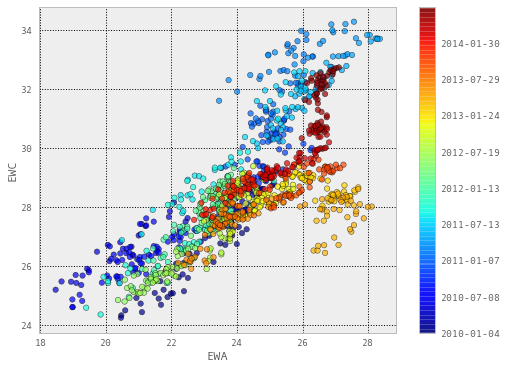

In [55]:
cm     = plt.cm.get_cmap('jet')
dates  = [str(p.date()) for p in data[::len(data)//10].index]
colors = np.linspace(0.1, 1, len(data))
sc     = plt.scatter(data[data.columns[0]], data[data.columns[1]], s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb     = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index]);
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1]);

Before we get started on the Kalman filter, recall the equation for a linear regression
$$a_k=\beta b_k+ \alpha$$

where $a_k$
and $b_k$ is the adjusted closing price of EWC and EWA respectively and $\beta$ and $\alpha$ are the slope and intercept.

Rewriting this in vector form gives $a_k = B \mathbf{b}_k$, where
$$\begin{aligned}
     &B = \left[\beta \alpha \right] \\
     &\mathbf{b}_k=\left[b_k 1 \right]^t
\end{aligned}$$

The Kalman filter is a linear state-space model that operates recursively on streams of noisy input data to produce a statistically optimal estimate of the underlying system state. The general form of the Kalman filter state-space model consits of a transition and observation equation
$$\begin{aligned}
   x_{k+1} =A_k x_k + w_k \\
   z_k=H_k x_k+v_k
\end{aligned}$$

where $x_k$$
and $z_k$ are the hidden state and observation vectors at time $k$.
$A_k$ and $H_k$ are the trasition and observation matrices.
$w_k$ and $v_k$$
are Guassian noise with zero mean.

For our application, we define $x_k$
to be the slope and intercept of the linear regression denoted by the vector $B$ above.
We also assume the slope and intercept follow a random walk by setting $A_k$
equal to the identity matrix. Our transition equation now looks like
$$B_{k+1}=I B_k+w_k$$

This simply says that $B$
for the next timestep is the current $B$
plus some noise.

The next step is to fit our model to the observation equation of the Kalman filter.

To do this, we make the EWC adjusted closing prices the observations $z_k$.

The observation matrix $H_k$ is a $p \times 2$ matrix consisting of the EWA adjusted closing price in the first column and ones in the second column. This is simply a linear regression between the two assests.

For pykalman, the observation matrix is constructed using<br>
`H_k = np.vstack([data.EWA, np.ones(data.EWA.shape)]).T[:, np.newaxis]`

The last thing we need to specify are the noise terms $w_k$ and $v_k$. We set the observation covariance $v_k$ to unity. We treat the transition covariance $w_k$ as a parameter that can be adjusted to control how quickly the slope and intercept change.

In [66]:
delta     = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)
H_k       = np.vstack([data.EWA, np.ones(data.EWA.shape)]).T[:, np.newaxis]

In [67]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean       = np.zeros(2),
                  initial_state_covariance = np.ones((2, 2)),
                  transition_matrices      = np.eye(2),
                  observation_matrices     = H_k,
                  observation_covariance   = 1.0,
                  transition_covariance    = trans_cov)

In [68]:
state_means, state_covs = kf.filter(data.EWC.values)

Plot the resulting intercept and slopes

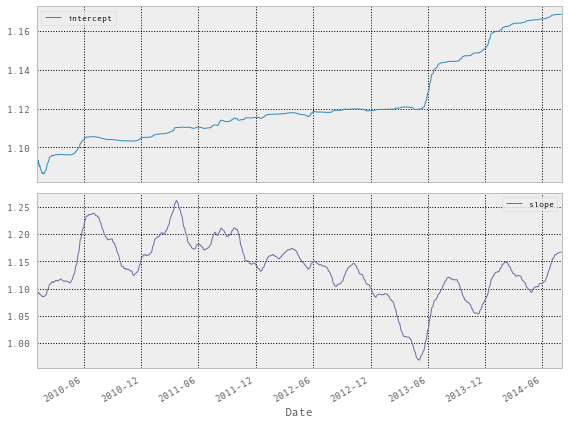

In [69]:
pd.DataFrame(dict(slope=state_means[:, 0], intercept=state_means[:, 1]), index=data.index).plot(subplots=True)
plt.tight_layout();

A more interesting way to visualize this is to overlay every fifth regression line on the EWA vs EWC scatter plot so we can clearly see the how the regression line adjusts over time 

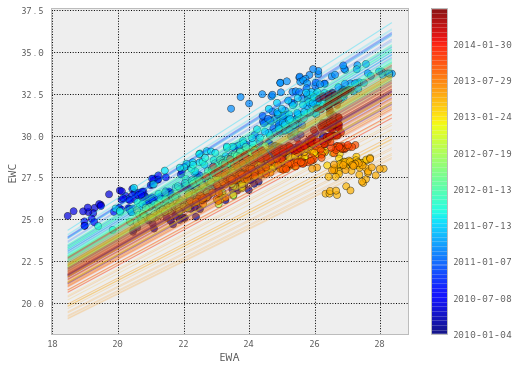

In [62]:
# visualize the correlation between assest prices over time
cm = plt.cm.get_cmap('jet')
dates = [str(p.date()) for p in data[::len(data)//10].index]
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[data.columns[0]], data[data.columns[1]], s=50, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index]);
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])

# add regression lines
step = 5
xi = np.linspace(data[data.columns[0]].min(), data[data.columns[0]].max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))